In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra import Model, Reaction, Metabolite
import os
from os.path import join
from util import *

### Chemostat simulatios

In [2]:
# Import  models
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated.xml"))

In [4]:
# Simulation with Yeast8
flux_y8, con_y8 = chemostat(
    model = model, 
    gecko = False, 
    growth_id = 'r_2111',
    glc_exchange_id = 'r_1714', 
    o2_exchange_id = 'r_1992',
    o2_id = 's_1277__91__e__93__',
    co2_id = 's_0458__91__e__93__',
    D_list = np.arange(0.05, 0.42, 0.02).tolist(), 
    V = 1, 
    c_sin = 7.5/0.18,
    F_g = 0.5*60, 
    c_ogin = 0.21*1000/(0.082 * (21+273)), 
    printing = False
)

con_y8.head()

D-glucose [extracellular]  H2O [extracellular]  biomass [cytoplasm]  \
D                                                                           
0.05               0.000000e+00           166.042969             3.551406   
0.07               0.000000e+00           164.484941             3.617311   
0.09              -4.934325e-15           163.594122             3.654993   
0.11               0.000000e+00           163.017510             3.679384   
0.13              -6.832142e-15           162.613802             3.696459   

      carbon dioxide [extracellular]  oxygen [extracellular]  
D                                                             
0.05                      105.181315              -98.067674  
0.07                      102.493849              -95.248198  
0.09                      100.957264              -93.636134  
0.11                       99.962658              -92.592672  
0.13                       99.266240              -91.862038

In [5]:
# Simulation with ecYeast8
flux_ec, con_ec = chemostat(
    model = model_ec, 
    gecko = True, 
    growth_id = 'r_2111',
    glc_exchange_id = 'r_1714_REV', 
    o2_exchange_id = 'r_1992_REV',
    o2_id = 's_1277__91__e__93__',
    co2_id = 's_0458__91__e__93__',
    D_list = np.arange(0.05, 0.42, 0.02).tolist(), 
    V = 1, 
    c_sin = 7.5/0.18,
    F_g = 0.5*60, 
    c_ogin = 0.21*1000/(0.082 * (21+273)), 
    printing = False
)
con_ec.head()

D-glucose [extracellular]  H+ [extracellular]  H2O [extracellular]  \
D                                                                          
0.05               0.000000e+00            1.914174           179.082317   
0.07               0.000000e+00            1.953330           177.631648   
0.09              -4.934325e-15            1.975783           176.799781   
0.11               8.074349e-15            1.990374           176.260364   
0.13               0.000000e+00            2.000580           175.882252   

     Infeasible  acetaldehyde [extracellular]  acetate [extracellular]  \
D                                                                        
0.05        NaN                           NaN                      NaN   
0.07        NaN                           NaN                      NaN   
0.09        NaN                           NaN                      NaN   
0.11        NaN                           NaN                      NaN   
0.13        NaN                           NaN                      NaN   

      biomass [cytoplasm]  carbon dioxide [extracellular]  \
D                                                           
0.05             3.606709                      116.487980   
0.07             3.680487                      113.756901   
0.09             3.722794                      112.190802   
0.11             3.750223                      111.175261   
0.13             3.769453                      110.463416   

      ethanol [extracellular]  pyruvate [extracellular]  
D                                                        
0.05                      NaN                       NaN  
0.07                      NaN                       NaN  
0.09                      NaN                       NaN  
0.11                      NaN                       NaN  
0.13                      NaN                       NaN

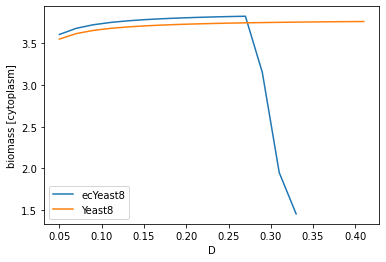

In [6]:
# Example visulization
plotting = 'biomass [cytoplasm]'
con_ec[plotting].plot(label='ecYeast8')
con_y8[plotting].plot(label='Yeast8')
plt.ylabel(plotting)
plt.legend()

### Batch simulations

In [7]:
# Import  models
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated.xml"))

In [8]:
# Example Yeast8
flux_y8, con_y8 = batch(
    model = model, 
    gecko=False, 
    cs_0=8/0.18, 
    cx_0=0.1, 
    V=0.215, 
    dt=0.5, 
    glc_exc_id='r_1714', 
    growth_id='r_2111', 
    qs_max=10, 
    kms=0.28, 
    t_end=15
)
con_y8.head()

Solution infeasible, t = 6.05


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                44.444444             0.100000                      0.0   
0  0.5                43.947575             0.145081                      0.0   
0  1.0                43.226761             0.210481                      0.0   
0  1.5                42.181128             0.305352                      0.0   
0  2.0                40.664436             0.442962                      0.0   

   carbon dioxide [extracellular]  glycolaldehyde [extracellular]  \
0                             NaN                             NaN   
0                        1.142899                        0.000003   
0                        2.800914                        0.000007   
0                        5.206079                        0.000013   
0                        8.694778                        0.000022   

   H2O [extracellular]  
0                  NaN  
0             1.915473  
0             4.694270  
0             8.725271  
0            14.572247

In [9]:
# Example ecYeast8

# Model modifications for batch simulation
#    - Increase protein pool exchange upper bound
prot_ub = model_ec.reactions.prot_pool_exchange.upper_bound
model_ec.reactions.prot_pool_exchange.upper_bound = 1.25 * prot_ub
#    - Allow ethanol export
model_ec.reactions.r_1761.upper_bound = 100


flux_ec, con_ec = batch(
    model = model_ec, 
    gecko=True, 
    cs_0=8/0.18, 
    cx_0=0.1,
    V=0.215, 
    dt=0.5, 
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=10, 
    kms=0.28, 
    t_end=15
)

con_ec.head()

Solution infeasible, t = 13.000000000000007


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                44.444444             0.100000                 0.000000   
0  0.5                43.947575             0.118345                 0.613166   
0  1.0                43.359596             0.140055                 1.338733   
0  1.5                42.663812             0.165748                 2.197279   
0  2.0                41.840477             0.196153                 3.213144   

   acetaldehyde [extracellular]  acetate [extracellular]  \
0                           NaN                      NaN   
0                      0.031000                 0.031000   
0                      0.067687                 0.067687   
0                      0.111104                 0.111104   
0                      0.162486                 0.162486   

   bicarbonate [extracellular]  carbon dioxide [extracellular]  \
0                          NaN                             NaN   
0                     0.001877                        0.942392   
0                     0.004098                        2.057599   
0                     0.006727                        3.377294   
0                     0.009838                        4.938942   

   pyruvate [extracellular]  H2O [extracellular]  
0                       NaN                  NaN  
0                  0.002500             0.650105  
0                  0.005459             1.419486  
0                  0.008960             2.330030  
0                  0.013104             3.407637

In [10]:
con_y8 = con_y8.set_index('t')
con_ec = con_ec.set_index('t')

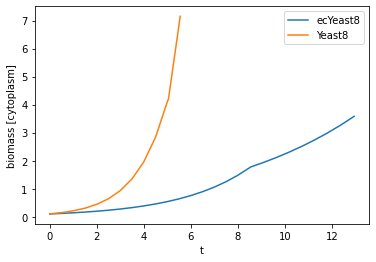

In [11]:
# Example visulization
plotting = 'biomass [cytoplasm]'
con_ec[plotting].plot(label='ecYeast8')
con_y8[plotting].plot(label='Yeast8')
plt.ylabel(plotting)
plt.legend()

### Fed-batch simulations

In [12]:
# Import  models
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated.xml"))

In [13]:
# Define feeding function
def feed(t):
    cs_in = 209/198*1e3 #mmol/kg
    # Batch lasts 4h, then exponential feed:
    t_start = 4
    if t <= t_start:
        F = 0
    else:
        F = 6e-5*np.exp(0.0636*(t-t_start)) #kg/h
    return(F, cs_in)

In [14]:
# Example yeast8
flux_y8, con_y8, v_y8 = fed_batch(
    model=model, 
    cs_0=2.5/198*1e3, 
    cx_0=0.275, #gDW/kg, 
    V_0=0.365, 
    feed=feed, 
    t_end=124, 
    t_lag=0.5, 
    dt=0.5, 
    gecko=False,
    glc_exc_id='r_1714',
    growth_id='r_2111',
    qs_max=10, 
    kms=0.28, 
)
con_y8.head()

Solution infeasible, t = 3.749999999999999


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                12.626263             0.275000                      0.0   
0  1.0                11.281093             0.397042                      0.0   
0  1.5                 9.343966             0.572787                      0.0   
0  2.0                 6.563353             0.825054                      0.0   
0  2.5                 2.606872             1.183984                      0.0   

   carbon dioxide [extracellular]  glycolaldehyde [extracellular]  \
0                             NaN                             NaN   
0                        3.094423                        0.000008   
0                        7.550649                        0.000019   
0                       13.947431                        0.000036   
0                       23.049920                        0.000059   

   H2O [extracellular]  
0                  NaN  
0             5.185893  
0            12.653937  
0            23.373903  
0            38.627503

In [15]:
# Example ecYeast8

# Model modifications for batch simulation
#    - Increase protein pool exchange upper bound
prot_ub = model_ec.reactions.prot_pool_exchange.upper_bound
model_ec.reactions.prot_pool_exchange.upper_bound = 1.25 * prot_ub
#    - Allow ethanol export
model_ec.reactions.r_1761.upper_bound = 100

flux_ec, con_ec, v_ec = fed_batch(
    model=model_ec, 
    cs_0=2.5/198*1e3, 
    cx_0=0.275, #gDW/kg, 
    V_0=0.365, 
    feed=feed, 
    t_end=124, 
    t_lag=0.5, 
    dt=0.5, 
    gecko=True,
    glc_exc_id='r_1714_REV',
    growth_id='r_2111',
    qs_max=10, 
    kms=0.28, 
)

con_ec.head()

t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0                12.626263             0.275000                 0.000000   
0  1.0                11.281093             0.325302                 1.642328   
0  1.5                 9.693977             0.384776                 3.576573   
0  2.0                 7.824105             0.455073                 5.849123   
0  2.5                 5.627357             0.538110                 8.506382   

   acetaldehyde [extracellular]  acetate [extracellular]  \
0                           NaN                      NaN   
0                      0.085250                 0.085250   
0                      0.186094                 0.186094   
0                      0.305374                 0.305374   
0                      0.446447                 0.446447   

   bicarbonate [extracellular]  carbon dioxide [extracellular]  \
0                          NaN                             NaN   
0                     0.005127                        2.557486   
0                     0.011185                        5.576182   
0                     0.018338                        9.134869   
0                     0.026773                       13.320033   

   pyruvate [extracellular]  H2O [extracellular]  
0                       NaN                  NaN  
0                  0.006875             1.795024  
0                  0.015008             3.919786  
0                  0.024627             6.435542  
0                  0.036004             9.415938

In [16]:
con_y8 = con_y8.set_index('t')
con_ec = con_ec.set_index('t')

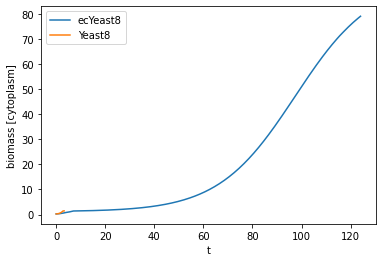

In [17]:
# Example visulization
plotting = 'biomass [cytoplasm]'
con_ec[plotting].plot(label='ecYeast8')
con_y8[plotting].plot(label='Yeast8')
plt.ylabel(plotting)
plt.legend()

### Batch with multiple C-sources: example glucose and sucrose

In [18]:
# Import  models
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated.xml"))

In [19]:
# Example Yeast8
# Define possible substrates and initial concentrations
dic_sub = {
    'D-glucose [extracellular]':['r_1714', 20/180e-3],
    'sucrose [extracellular]':['r_2058', 15/342e-3],
    'D-fructose [extracellular]': ['r_1709', 0]
}

flux_gs_y8, con_gs_y8 = batch_multipleC(
    model=model,
    gecko=False,
    growth_id = 'r_2111',
    dic_sub=dic_sub, 
    cx_0=1e-3,
    V=3.5,
    dt=0.5,
    t_end=25
)
con_gs_y8.head()

Negative D-fructose [extracellular] concentration (0.0) at t = 0.5
Negative D-fructose [extracellular] concentration (0.0) at t = 1.0
Negative D-fructose [extracellular] concentration (0.0) at t = 1.5
Negative D-fructose [extracellular] concentration (0.0) at t = 2.0
Negative D-fructose [extracellular] concentration (0.0) at t = 2.5
Negative D-fructose [extracellular] concentration (0.0) at t = 3.0
Negative D-fructose [extracellular] concentration (0.0) at t = 3.5
Negative D-fructose [extracellular] concentration (0.0) at t = 4.0
Negative D-fructose [extracellular] concentration (0.0) at t = 4.5
Negative D-fructose [extracellular] concentration (0.0) at t = 5.0
Negative sucrose [extracellular] concentration (-11.84060833066583) at t = 5.5
Negative D-fructose [extracellular] concentration (0.0) at t = 5.5
Negative D-glucose [extracellular] concentration (-392.9355403273155) at t = 6.0
Negative sucrose [extracellular] concentration (0.0) at t = 6.0
Negative D-fructose [extracellular] con

t  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0             0.001000                        0   
0  0.5             0.002364                        0   
0  1.0             0.005589                        0   
0  1.5             0.013212                        0   
0  2.0             0.031234                        0   

   D-glucose [extracellular]  sucrose [extracellular]  \
0                 111.111111                43.859649   
0                 111.101111                43.854649   
0                 111.077471                43.842829   
0                 111.021583                43.814885   
0                 110.889462                43.748825   

   D-fructose [extracellular]  carbon dioxide [extracellular]  \
0                         0.0                             NaN   
0                         0.0                        0.034377   
0                         0.0                        0.115645   
0                         0.0                        0.307769   
0                         0.0                        0.761958   

   glycolaldehyde [extracellular]  H2O [extracellular]  
0                             NaN                  NaN  
0                    8.811783e-08             0.052753  
0                    2.964331e-07             0.177464  
0                    7.889014e-07             0.472288  
0                    1.953123e-06             1.169266

In [20]:
# Model modifications for batch simulation
#    - Increase protein pool exchange upper bound
prot_ub = model_ec.reactions.prot_pool_exchange.upper_bound
model_ec.reactions.prot_pool_exchange.upper_bound = 1.25 * prot_ub
#    - Allow ethanol export
model_ec.reactions.r_1761.upper_bound = 100

# Define possible substrates and initial concentrations
dic_sub = {
    'D-glucose [extracellular]':['r_1714_REV', 20/180e-3],
    'sucrose [extracellular]':['r_2058_REV', 15/342e-3],
    'D-fructose [extracellular]': ['r_1709_REV', 0]
}

flux_gs, con_gs = batch_multipleC(
    model=model_ec,
    gecko=True,
    growth_id = 'r_2111',
    dic_sub=dic_sub, 
    cx_0=1e-3,
    V=3.5,
    dt=0.5,
    t_end=25
)

con_gs.head()

Negative D-glucose [extracellular] concentration (-4.664979452071911) at t = 22.5
Negative sucrose [extracellular] concentration (-12.168845229887765) at t = 23.5


t  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0             0.001000                 0.000000   
0  0.5             0.001194                 0.012073   
0  1.0             0.001425                 0.026484   
0  1.5             0.001701                 0.043687   
0  2.0             0.002031                 0.064222   

   D-glucose [extracellular]  sucrose [extracellular]  \
0                 111.111111                43.859649   
0                 111.103566                43.859649   
0                 111.094560                43.859649   
0                 111.083809                43.859649   
0                 111.070976                43.859649   

   D-fructose [extracellular]  bicarbonate [extracellular]  \
0                         0.0                          NaN   
0                         0.0                     0.000046   
0                         0.0                     0.000101   
0                         0.0                     0.000167   
0                         0.0                     0.000246   

   carbon dioxide [extracellular]  formate [extracellular]  \
0                             NaN                      NaN   
0                        0.013900                 0.000006   
0                        0.030492                 0.000013   
0                        0.050298                 0.000022   
0                        0.073942                 0.000032   

   H2O [extracellular]  ammonium [extracellular]  oxygen [extracellular]  \
0                  NaN                       NaN                     NaN   
0             0.005189                  0.001310                0.001542   
0             0.011384                  0.002874                0.003383   
0             0.018778                  0.004741                0.005581   
0             0.027605                  0.006970                0.008205   

   phosphate [extracellular]  sulphate [extracellular]  prot_pool [cytoplasm]  \
0                        NaN                       NaN                    NaN   
0                   0.000046                  0.000018               0.049925   
0                   0.000101                  0.000039               0.109522   
0                   0.000167                  0.000064               0.180663   
0                   0.000246                  0.000094               0.265586   

   H+ [extracellular]  acetaldehyde [extracellular]  acetate [extracellular]  \
0                 NaN                           NaN                      NaN   
0                 NaN                           NaN                      NaN   
0                 NaN                           NaN                      NaN   
0                 NaN                           NaN                      NaN   
0                 NaN                           NaN                      NaN   

   pyruvate [extracellular]  
0                       NaN  
0                       NaN  
0                       NaN  
0                       NaN  
0                       NaN

In [22]:
# Import  models
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated.xml"))

In [23]:
# Example Yeast8 with additional regulation

# Model modifications for batch simulation
#    - Increase protein pool exchange upper bound
prot_ub = model_ec.reactions.prot_pool_exchange.upper_bound
model_ec.reactions.prot_pool_exchange.upper_bound = 1.25 * prot_ub
#    - Allow ethanol export
model_ec.reactions.r_1761.upper_bound = 100

# Define possible substrates and initial concentrations
dic_sub = {
    'D-glucose [extracellular]':['r_1714_REV', 20/180e-3],
    'sucrose [extracellular]':['r_2058_REV', 15/342e-3],
    'D-fructose [extracellular]': ['r_1709_REV', 0]
}
flux_gs_reg, con_gs_reg = batch_multipleC_reg(
    model=model_ec,
    growth_id='r_2111',
    dic_sub=dic_sub, 
    cx_0=1e-3,
    V=3.5,
    dt=0.5,
    t_end = 25
)

D-glucose [extracellular] concentration (-66.74118007955323) at t = 23.5, fixed to 0
sucrose [extracellular] concentration (-57.36146477639464) at t = 24.0, fixed to 0


In [24]:
con_gs = con_gs.set_index('t')
con_gs_y8 = con_gs_y8.set_index('t')
con_gs_reg = con_gs_reg.set_index('t')

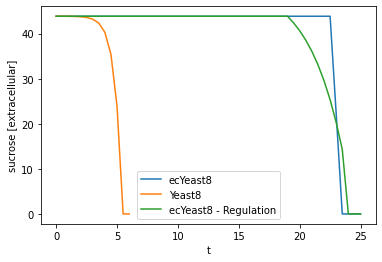

In [25]:
# Example visulization
plotting = 'sucrose [extracellular]'
con_gs[plotting].plot(label='ecYeast8')
con_gs_y8[plotting].plot(label='Yeast8')
con_gs_reg[plotting].plot(label='ecYeast8 - Regulation')
plt.ylabel(plotting)
plt.legend()

### Simulations with lactate producing strain

In [26]:
# Import  models
# These models contains all the modifications as described in the manuscript
data_dir = './data'
model = cobra.io.read_sbml_model(join(data_dir, "yeastGEM_lactate.xml"))
model_ec = cobra.io.read_sbml_model(join(data_dir, "ecYeast8_updated_lactate.xml"))

In [27]:
flux, con, = batch_o2lim(
    model=model, 
    gecko=False,
    cs_0=100/0.18, 
    cx_0=0.05, 
    V=1, 
    dt=0.5, 
    glc_exc_id='r_1714', 
    growth_id='r_2111', 
    qs_max=10, 
    kms=0.28,
    t_end=180)
con.head()

Solution infeasible, t = 154.15000000000003


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0               555.555556             0.050000                      0.0   
0  0.5               555.509079             0.053250                      0.0   
0  1.0               555.459581             0.056711                      0.0   
0  1.5               555.406865             0.060397                      0.0   
0  2.0               555.350724             0.064323                      0.0   

   carbon dioxide [extracellular]  formate [extracellular]  \
0                             NaN                      NaN   
0                        0.065361                 0.080964   
0                        0.134971                 0.167191   
0                        0.209105                 0.259022   
0                        0.288059                 0.356823   

   glycolaldehyde [extracellular]  H2O [extracellular]  \
0                             NaN                  NaN   
0                    2.099500e-07             0.121060   
0                    4.335468e-07             0.249990   
0                    6.716773e-07             0.387299   
0                    9.252863e-07             0.533534   

   (R)-lactate [extracellular]  isobutanol [extracellular]  \
0                          NaN                         NaN   
0                          NaN                         NaN   
0                          NaN                         NaN   
0                          NaN                         NaN   
0                          NaN                         NaN   

   succinate [extracellular]  stearate [extracellular]  
0                        NaN                       NaN  
0                        NaN                       NaN  
0                        NaN                       NaN  
0                        NaN                       NaN  
0                        NaN                       NaN

In [28]:
flux_ec, con_ec, = batch_o2lim(
    model=model_ec, 
    gecko=True,
    cs_0=100/0.18, 
    cx_0=0.05, 
    V=1, 
    dt=0.5, 
    glc_exc_id='r_1714_REV', 
    growth_id='r_2111', 
    qs_max=10, 
    kms=0.28,
    t_end=180)
con_ec.head()

Solution infeasible, t = 150.30000000000007


t  glucose [extracellular]  biomass [cytoplasm]  ethanol [extracellular]  \
0  0.0               555.555556             0.050000                      0.0   
0  0.5               555.418490             0.053250                      0.0   
0  1.0               555.272516             0.056711                      0.0   
0  1.5               555.117053             0.060397                      0.0   
0  2.0               554.951485             0.064323                      0.0   

   (R)-lactate [extracellular]  carbon dioxide [extracellular]  \
0                          NaN                             NaN   
0                     0.223130                        0.032687   
0                     0.460764                        0.067498   
0                     0.713844                        0.104573   
0                     0.983375                        0.144057   

   H+ [extracellular]  H2O [extracellular]  succinate [extracellular]  
0                 NaN                  NaN                        NaN  
0            0.222355             0.089090                        NaN  
0            0.459164             0.183971                        NaN  
0            0.711365             0.285019                        NaN  
0            0.979959             0.392636                        NaN

In [29]:
con = con.set_index('t')
con_ec = con_ec.set_index('t')

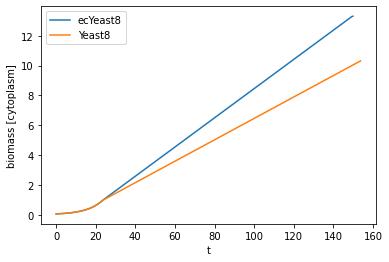

In [30]:
# Example visulization
plotting = '(R)-lactate [extracellular]'
plotting = 'biomass [cytoplasm]'
con_ec[plotting].plot(label='ecYeast8')
con[plotting].plot(label='Yeast8')
plt.ylabel(plotting)
plt.legend()